# Scattering 
## Computational Nuclear Physics
### Project 4

### Papadopoulou Martha

### Import Libraries

In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error

# Momentum Transfer and Scattering Angle Relation

In [2]:
# Define symbols
E, c, hbar, theta = sp.symbols('E c hbar theta', real=True, positive=True)

# Define initial and final directions 
i = sp.Matrix([1, 0, 0]) # x-axis
f = sp.Matrix([sp.cos(theta), sp.sin(theta), 0]) # in x-axis -> cos(theta) and y-axis -> sin(theta)

# Define momentum
k = E / (hbar*c) # p = hbar * k

# Define initial and final momenta
k_i = k * i
k_f = k * f

# Calculate momentum transfer vector
q_vec = k_f - k_i 

# Calculate magnitude of q vector
q_squared = q_vec.dot(q_vec)
q_expr = sp.sqrt(q_squared)

# Simplify and print result
q_simple = sp.simplify(q_expr)
print("|q| = ", q_simple)

# Convert cos(theta) to (sin(theta/2))^2
q_sin = q_simple.subs(sp.cos(theta), 1 - 2 * sp.sin(theta/2)**2)
print("|q| = ", q_sin)

|q| =  E*sqrt(2 - 2*cos(theta))/(c*hbar)
|q| =  2*E*Abs(sin(theta/2))/(c*hbar)


# Differential Cross-Section and Charge Density Relations

### Define and Normalize Charge Density rho_ch

In [3]:
def norm_rho_ch(Z, R, a):

    # Define symbol
    r = sp.Symbol('r', real=True, positive=True)

    # Define charge density
    rho_ch = 1 / (1 + sp.exp((r-R)/a)) # leave out rho0 to calculate later

    # Integrate numerically
    rho_num = sp.lambdify(r, rho_ch * r**2, modules='numpy')
    integral_val, _ = quad(rho_num, 0, int(R*15)) # skip error value

    # Calculate rho_0
    rho_0 = Z / (4 * np.pi * integral_val)
    return rho_0

def rho_ch(r, rho_0, R, a):
    rho = rho_0 / (1 + np.exp((r-R)/a))
    return rho

### Compute and Plot Charge Density for Pb-208 (Z=82) for Validation

In [4]:
# Values taken from Table 4.1 of "Introduction to Nuclear Physics - Cottingham"
nucleus = {
    "name": "Pb-208",
    "Z": 82,
    "R": 6.65, # fm
    "a": 0.526 # fm
}

# Calculate rho_0
rho_0 = norm_rho_ch(nucleus["Z"], nucleus["R"], nucleus["a"])
print(f"For {nucleus['name']} the rho0_ch = {rho_0:.4f} fm^(-3)")

For Pb-208 the rho0_ch = 0.0627 fm^(-3)


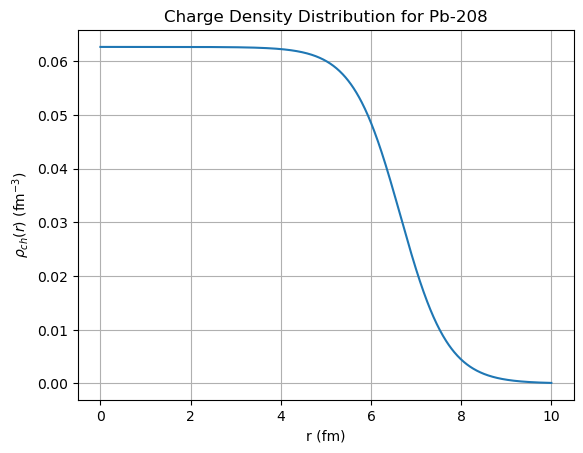

In [5]:
# Plot charge density against distance
r_val = np.linspace(0, 10, 1000)
rho_val = rho_ch(r_val, rho_0, nucleus["R"], nucleus["a"])

plt.plot(r_val, rho_val)
plt.xlabel("r (fm)")
plt.ylabel(r"$\rho_{ch}(r)$ (fm$^{-3}$)")
plt.title(f"Charge Density Distribution for {nucleus['name']}")
plt.grid(True)
plt.show()

### Prove Cross-Section and Charge Density Relation

In [6]:
# Define symbols
r, q, rhoch, e, epsilon_0 = sp.symbols('r q rho_ch e epsilon_0', real=True, positive=True)
q_dot_r, phi_c = sp.symbols('q.r phi_c', real=True)
d3r = sp.Symbol('^3r', real=True) 

# Define constant part symbolically
const_expr = (E / (2 * sp.pi))**2 * (1 / (hbar * c))**4 * e**2

# Define the integral part symbolically
integr_expr = sp.Integral(phi_c * sp.exp(sp.I * q_dot_r), d3r)

# Full expression for differential cross-section
diff_cross_section = const_expr * integr_expr**2
print("Original expression:")
display(diff_cross_section)

Original expression:


E**2*e**2*Integral(phi_c*exp(I*q.r), ^3r)**2/(4*pi**2*c**4*hbar**4)

In [7]:
# Replace e^(i q.r) with Laplacian e^(i q.r) (∇^2 e^(i q.r) = - q^2 e^(i q.r))
# then replace Laplacian phi_c with rho_ch (∇^2 phi_c = -e rho_ch / epsilon_0)
subs_dict = {phi_c: -(e * rhoch) / epsilon_0, sp.exp(sp.I * q_dot_r): (-1/q**2) * sp.exp(sp.I * q_dot_r)}

# Perform substitution inside the integral
diff_cross_section_subs = diff_cross_section.subs(subs_dict)
print("After substitution:")
display(diff_cross_section_subs)

After substitution:


E**2*e**2*Integral(e*rho_ch*exp(I*q.r)/(epsilon_0*q**2), ^3r)**2/(4*pi**2*c**4*hbar**4)

In [8]:
# Rewrite differential cross-section expression
constant_expr = (E/(2*sp.pi))**2 * (1/(hbar*c))**4 * (1/q)**4 * (e**2/epsilon_0)**2
integral_expr = sp.Integral(rhoch * sp.exp(sp.I * q_dot_r), d3r)
dsigma_domega = constant_expr * integral_expr**2
print("Rewritten expression:")
display(dsigma_domega)

Rewritten expression:


E**2*e**4*Integral(rho_ch*exp(I*q.r), ^3r)**2/(4*pi**2*c**4*epsilon_0**2*hbar**4*q**4)

### Convert Integral to Spherical Coordinates

In [9]:
# Define extra needed symbols 
phi = sp.Symbol('phi', real=True, positive=True)

# Convert to spherical coordinates and align q with z-axis
integral_sph_expr = sp.Integral(1, (phi, 0, 2*sp.pi)) * sp.Integral(rhoch * r**2 *
                            sp.Integral(sp.exp(sp.I * q * r * sp.cos(theta)) * sp.sin(theta), (theta, 0, sp.pi)), 
                                                                    (r, 0, sp.oo))
ds_do_sph = constant_expr * integral_sph_expr**2
print("In spherical coordinates:")
display(ds_do_sph)

In spherical coordinates:


E**2*e**4*Integral(1, (phi, 0, 2*pi))**2*Integral(r**2*rho_ch*Integral(exp(I*q*r*cos(theta))*sin(theta), (theta, 0, pi)), (r, 0, oo))**2/(4*pi**2*c**4*epsilon_0**2*hbar**4*q**4)

### Calculate Angular Integrals

In [10]:
# Calculate inner theta integral
theta_integral = sp.Integral(sp.exp(sp.I * q * r * sp.cos(theta)) * sp.sin(theta), (theta, 0, sp.pi))
theta_int = theta_integral.doit().simplify()
print("Inner theta integral:")
display(theta_int)

# Calculate phi integral 
phi_integral = sp.Integral(1, (phi, 0, 2*sp.pi))
phi_int = phi_integral.doit()
print("Phi integral:")
display(phi_int)

Inner theta integral:


2*sin(q*r)/(q*r)

Phi integral:


2*pi

# Calculate and Plot Differential Cross-Section

In [11]:
def cal_cross_section(nucleus, E, theta_1):
    
    # Define constants
    hbar_c = 197.327 # MeV * fermi
    alpha = 1/137.036 # a = e^2 /(4π ε_0 hbar c)

    # Name nucleus variables for clarity
    Z = nucleus["Z"]
    R = nucleus["R"]
    a = nucleus["a"]

    # Normalize rho_ch
    rho_0_2 = norm_rho_ch(Z, R, a)

    # Calculate magnitute of momentum transfer
    q = 2 * E * np.sin(theta_1/2) / hbar_c

    # Calculate constant part of the cross-section expression 
    constant = (2*np.pi)**2 * E**2 * (1/(hbar_c))**2 * (1/q)**4 * 4*alpha**2 

    # Calculate integral part of the cross-section expression 
    def integrand(r):
        return rho_ch(r, rho_0_2, R, a) * r**2 * 2 * np.sin(q*r) / (q*r)

    result, _ = quad(integrand, 0.1, 15)

    # Calculate and return full expression
    final_result = constant * result**2
    
    return final_result

### Define All Variables of Au-197 for Validation

In [12]:
# Values taken from "Introduction to Nuclear Physics - Cottingham"
nucleus_2 = {
    "name": "Au-197",
    "Z": 79,
    "R": 6.63, # fm
    "a": 0.45 # fm
}

# Energies for validation
E_vals = [126, 183] # MeV

### Plot Differential Cross-Section of Au-197 for Validation

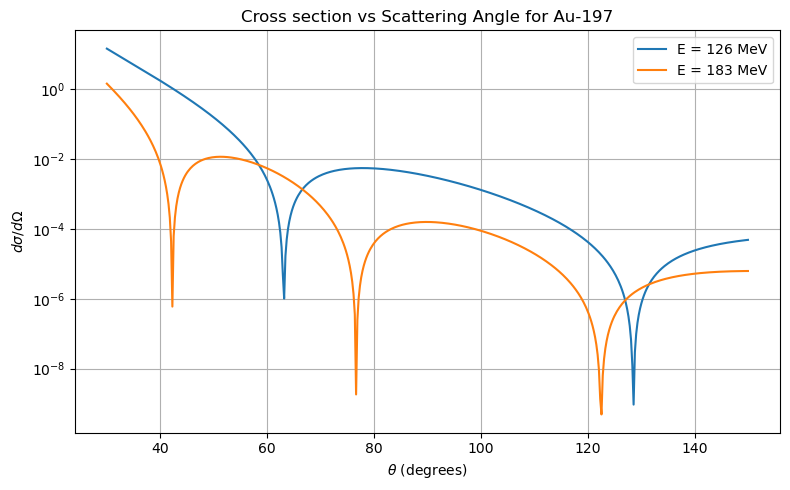

In [13]:
# Create theta values in degrees and convert to radians
theta_degrees = np.linspace(30, 150, 500) 
theta_radians = np.radians(theta_degrees)

# Plot
plt.figure(figsize=(8, 5))

# Compute dσ/dΩ for each energy
for E in E_vals:
    cross_sections = []
    for theta in theta_radians:
        sigma = cal_cross_section(nucleus_2, E, theta)
        cross_sections.append(sigma)
    plt.plot(theta_degrees, cross_sections, label=f"E = {E} MeV")

# Labels
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\sigma/d\Omega$')
plt.title(f'Cross section vs Scattering Angle for {nucleus_2["name"]}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compare Model with Experimental Data for Au-197

### Load Experimental Data


In [14]:
# Data points were taken from Fig 4.1 of "Introduction to Nuclear Physics - Cottingham" 
# using the tool available at automeris.io/wpd/ and saved as csv

# Load datasets 
data_df = pd.read_csv('wpd_datasets.csv')
data_df = data_df.apply(pd.to_numeric, errors='coerce') 

# Split datasets and coordinates
x_126 = data_df.iloc[:,0].dropna()
y_126 = data_df.iloc[:,1].dropna()
x_183 = data_df.iloc[:,2].dropna()
y_183 = data_df.iloc[:,3].dropna()

### Plot Data and Model

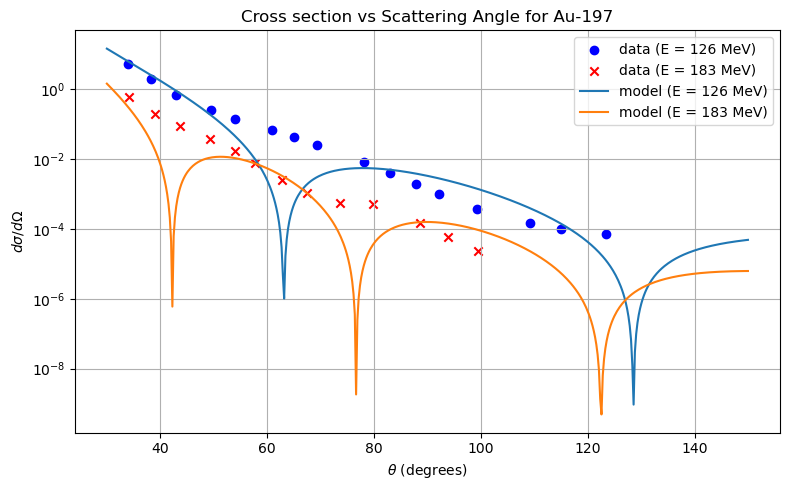

In [15]:
# Plot
plt.figure(figsize=(8, 5))

# Scatter plot experimental data
plt.scatter(x_126, y_126, label='data (E = 126 MeV)', marker='o', color='blue')
plt.scatter(x_183, y_183, label='data (E = 183 MeV)', marker='x', color='red')

# Compute dσ/dΩ for each energy
for E in E_vals:
    cross_sections = []
    for theta in theta_radians:
        sigma = cal_cross_section(nucleus_2, E, theta)
        cross_sections.append(sigma)
    plt.plot(theta_degrees, cross_sections, label=f"model (E = {E} MeV)")

# Labels
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\sigma/d\Omega$')
plt.title(f'Cross section vs Scattering Angle for {nucleus_2["name"]}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Calculate Model Predictions with Mean Absolute Error

In [16]:
# Calculate predicted y values for x points for 126 MeV
x_126_radians = np.radians(x_126)
y_126_model = []
for th in x_126_radians:
    y = cal_cross_section(nucleus_2, 126, th)
    y_126_model.append(y)

# Calculate mean absolute error for 126 MeV
mae_126 = mean_absolute_error(y_126, y_126_model) 
print(f"For {nucleus_2['name']} and E = 126 MeV the mean absolute error is {mae_126:.4f}")

For Au-197 and E = 126 MeV the mean absolute error is 0.1262


In [17]:
# Calculate predicted y values for x points for 126 MeV
x_183_radians = np.radians(x_183)
y_183_model = []
for th in x_183_radians:
    y = cal_cross_section(nucleus_2, 183, th)
    y_183_model.append(y)

# Calculate mean absolute error for 126 MeV
mae_183 = mean_absolute_error(y_183, y_183_model) 
print(f"For {nucleus_2['name']} and E = 183 MeV the mean absolute error is {mae_183:.4f}")

For Au-197 and E = 183 MeV the mean absolute error is 0.0476


# Determine Parameters a and R for Model Optimization 

### Define Optimization Function

In [18]:
def optimization(parameters, datasets):
    # Define parameters R and a
    R, a = parameters

    # Define nucleus (Au-197 as an example)
    nucleus = {
        "name": "Au-197",
        "Z": 79,
        "R": R,
        "a": a 
    }

    # Initialize empty y lists
    y_expected_all = []
    y_predicted_all = []
    for E, x_expected, y_expected in datasets:
        
        # Calculate predicted y values
        x_radians = np.radians(x_expected)
        y_predicted = [cal_cross_section(nucleus, E, th) for th in x_radians]

        # Gather y values
        y_expected_all.extend(y_expected)
        y_predicted_all.extend(y_predicted)
    

    # Calculate mean squared error 
    mae = mean_absolute_error(y_expected_all, y_predicted_all)
    return mae

### Calculate R and a Parameters that Minimize Mean Absolute Error

In [19]:
# Define bounds for R and a 
bounds =[(5,8), (0.2,0.8)]

# Define initial guess using book values
initial_guess = [nucleus_2['R'], nucleus_2['a']]

# Define datasets
datasets = [ (126, x_126, y_126),
            (150, x_183, y_183) ]

# Use minimize function to find R and a values for minimum rmse
result = minimize(optimization, initial_guess, args=(datasets), bounds=bounds)

# Print results
best_R, best_a = result.x
min_mae = result.fun
print(f"Optimized R: {best_R:.4f}, a: {best_a:.4f}")
print(f"Minimum MAE: {min_mae:.6f}")

Optimized R: 6.7758, a: 0.5821
Minimum MAE: 0.059790


### Plot Data and Model with Optimized Parameters

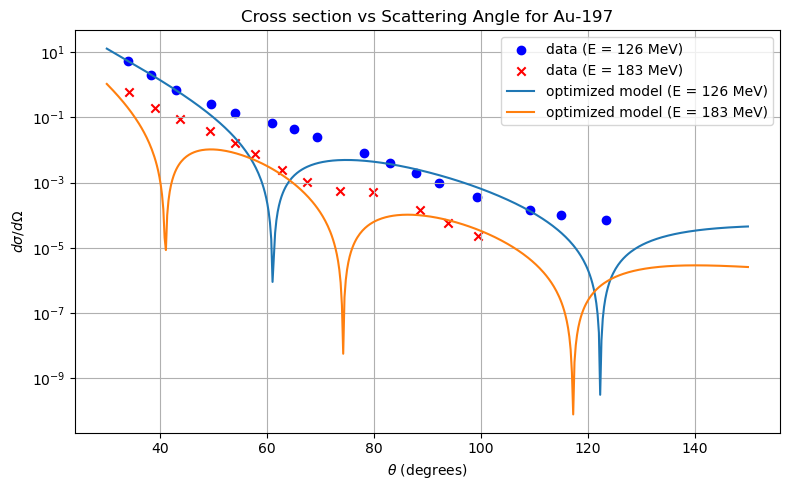

In [20]:
# Define same nucleus with the new R and a values
nucleus_3 = {
    "name": "Au-197",
    "Z": 79,
    "R": best_R, # fm
    "a": best_a # fm
}

# Plot
plt.figure(figsize=(8, 5))

# Scatter plot experimental data
plt.scatter(x_126, y_126, label='data (E = 126 MeV)', marker='o', color='blue')
plt.scatter(x_183, y_183, label='data (E = 183 MeV)', marker='x', color='red')

# Compute dσ/dΩ for each energy
for E in E_vals:
    cross_sections = []
    for theta in theta_radians:
        sigma = cal_cross_section(nucleus_3, E, theta)
        cross_sections.append(sigma)
    plt.plot(theta_degrees, cross_sections, label=f"optimized model (E = {E} MeV)")

# Labels
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\sigma/d\Omega$')
plt.title(f'Cross section vs Scattering Angle for {nucleus_2["name"]}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Plot both Models for Comparison

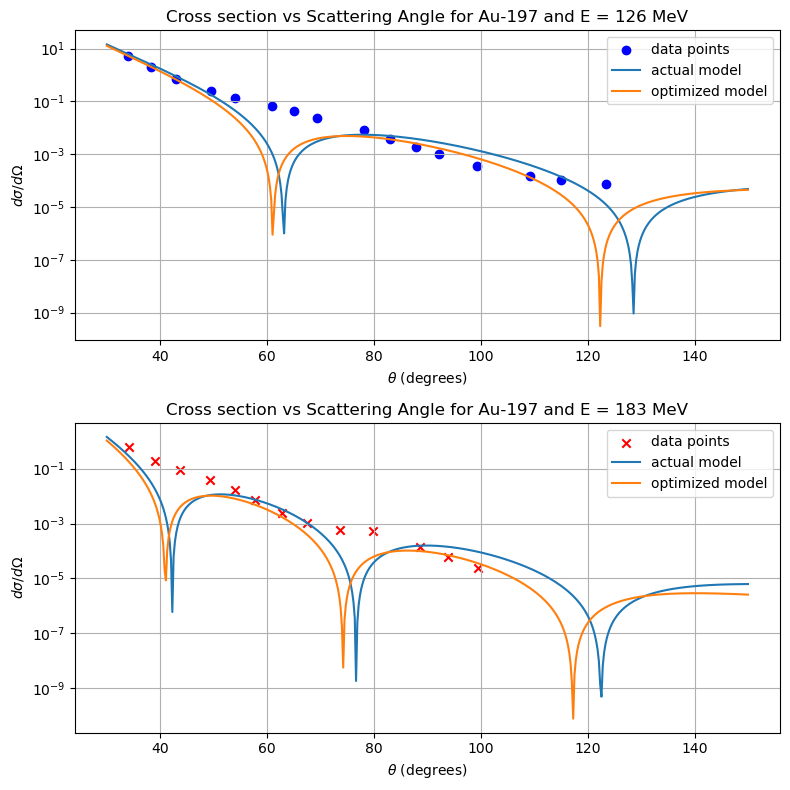

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Subplot for E = 126 MeV
# Scatter points
axes[0].scatter(x_126, y_126, label='data points', marker='o', color='blue')

# Compute and plot dσ/dΩ 
cross_sections_1 = []
cross_sections_2 = []
for theta in theta_radians:
    sigma_1 = cal_cross_section(nucleus_2, 126, theta)
    cross_sections_1.append(sigma_1)
    sigma_2 = cal_cross_section(nucleus_3, 126, theta)
    cross_sections_2.append(sigma_2)
axes[0].plot(theta_degrees, cross_sections_1, label=f"actual model")
axes[0].plot(theta_degrees, cross_sections_2, label=f"optimized model")

# Labels and formatting
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$\theta$ (degrees)')
axes[0].set_ylabel(r'$d\sigma/d\Omega$')
axes[0].set_title(f'Cross section vs Scattering Angle for {nucleus_2["name"]} and E = 126 MeV')
axes[0].grid(True)
axes[0].legend()


# Subplot for E = 183 MeV
# Scatter points
axes[1].scatter(x_183, y_183, label='data points', marker='x', color='red')

# Compute and plot dσ/dΩ
cross_sections_3 = []
cross_sections_4 = []
for theta in theta_radians:
    sigma_3 = cal_cross_section(nucleus_2, 183, theta)
    cross_sections_3.append(sigma_3)
    sigma_4 = cal_cross_section(nucleus_3, 183, theta)
    cross_sections_4.append(sigma_4)
axes[1].plot(theta_degrees, cross_sections_3, label=f"actual model")
axes[1].plot(theta_degrees, cross_sections_4, label=f"optimized model")

# Labels and formatting
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$\theta$ (degrees)')
axes[1].set_ylabel(r'$d\sigma/d\Omega$')
axes[1].set_title(f'Cross section vs Scattering Angle for {nucleus_2["name"]} and E = 183 MeV')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()